readme = f"""
# Kelime Öğrenme için Çok-Etiketli Görüntü Sınıflandırma (COCO 2017)

**Amaç:** Görüntüdeki nesnelerin İngilizce isimlerini listeleyen, YOLO kullanmadan sıfırdan CNN tabanlı sistem.

## Veri
- COCO 2017 train/val/test

## Yöntem
- Çok-etiketli sınıflandırma (multi-label)
- TinyCNN (Conv+BN+ReLU, Pooling, Dropout, Dense)
- BCEWithLogitsLoss + Adam
- Augmentations: Flip, Bright/Contrast, ColorJitter, letterbox

## Değerlendirme
- Loss ve Makro F1 grafikleri
- Grad-CAM ısı haritaları

## Çıktılar
- `/kaggle/working/preds/manifest.csv`
- `_words.jpg` örnek görseller

## Kaggle Notebook
- (kendi linkini ekle)
"""
print(readme)


In [1]:
# Hücre 0 – Kurulum ve sürüm kontrolü

import sys, subprocess, pkgutil

def pip_install(pkg):
    # Eğer paket yoksa pip ile kur
    installed = {m.name for m in pkgutil.iter_modules()}
    if pkg not in installed:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# Gerekirse aç:
# pip_install("pillow")
# pip_install("opencv-python")
# pip_install("pytorch-grad-cam")

import torch, torchvision
print("Torch:", torch.__version__, "| Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch: 2.6.0+cu124 | Torchvision: 0.21.0+cu124
CUDA available: True


In [2]:
import os, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as T

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cuda')

In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

base_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

def show_image(img_bgr, title=None):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()


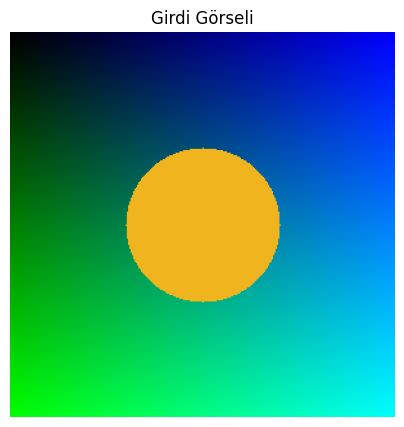

In [4]:
# Hücre 3 (vektörize, önerilen)
IMG_PATH = None

if IMG_PATH and os.path.exists(IMG_PATH):
    img_bgr = cv2.imread(IMG_PATH)
else:
    h, w = 300, 300
    x = np.linspace(0, 255, w, dtype=np.uint8)
    y = np.linspace(0, 255, h, dtype=np.uint8)
    img_bgr = np.zeros((h, w, 3), dtype=np.uint8)
    img_bgr[..., 0] = x            # B kanalı: yatay gradyan
    img_bgr[..., 1] = y[:, None]   # G kanalı: dikey gradyan
    cv2.circle(img_bgr, (w//2, h//2), 60, (30, 180, 240), -1)

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis('off'); plt.title("Girdi Görseli"); plt.show()


In [5]:
from torchvision import models

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.eval().to(DEVICE)

idx_to_class = models.ResNet50_Weights.IMAGENET1K_V2.meta["categories"]

pil_img = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
img_tensor = base_transform(pil_img).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    logits = model(img_tensor)
    probs = F.softmax(logits, dim=1)[0]

topk = torch.topk(probs, k=5)
for rank, (p, idx) in enumerate(zip(topk.values.tolist(), topk.indices.tolist()), start=1):
    print(f"{rank}) {idx_to_class[idx]} — {p:.3f}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s] 


1) lemon — 0.124
2) orange — 0.083
3) balloon — 0.055
4) tennis ball — 0.024
5) croquet ball — 0.015


In [6]:
tr_map = {"tabby": "tekir kedi", "tiger cat": "kaplan desenli kedi", "banana": "muz"}

for rank, (p, idx) in enumerate(zip(topk.values.tolist(), topk.indices.tolist()), start=1):
    en_label = idx_to_class[idx]
    tr_label = tr_map.get(en_label, en_label)
    print(f"{rank}) {tr_label} — {p:.3f}")


1) lemon — 0.124
2) orange — 0.083
3) balloon — 0.055
4) tennis ball — 0.024
5) croquet ball — 0.015


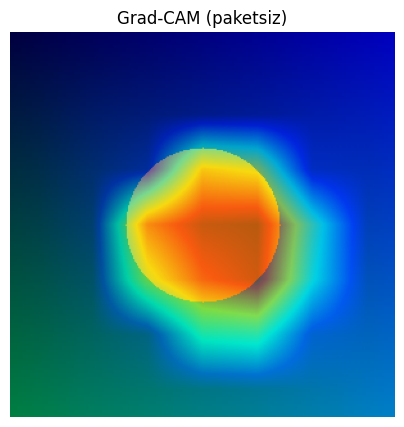

In [7]:
# Hücre 6 (PAKETSİZ Grad-CAM) – boyut uyumu düzeltilmiş
import torch, cv2, numpy as np, matplotlib.pyplot as plt

# model (ResNet50), img_tensor (1x3x224x224), img_bgr, topk önceki hücrelerden gelmeli
model.eval()

# 1) Hedef katman: ResNet50 son konv bloğu
target_block = model.layer4[-1]
acts, grads = [], []

def fwd_hook(module, inp, out):
    acts.append(out.detach())

def bwd_hook(module, grad_in, grad_out):
    grads.append(grad_out[0].detach())

h1 = target_block.register_forward_hook(fwd_hook)
h2 = target_block.register_full_backward_hook(bwd_hook)

# 2) İleri + geri
model.zero_grad(set_to_none=True)
logits = model(img_tensor)
cls_idx = int(topk.indices[0])        # en olası sınıf
score = logits[0, cls_idx]
score.backward()

h1.remove(); h2.remove()

# 3) Grad-CAM hesapla
A = acts[0]                         # [1,C,H',W']
G = grads[0]                        # [1,C,H',W']
weights = G.mean(dim=(2,3), keepdim=True)
cam = (weights * A).sum(dim=1, keepdim=True)      # [1,1,H',W']
cam = torch.relu(cam).squeeze(0).squeeze(0)       # [H',W']

# 4) CAM'i ORİJİNAL görsel boyutuna ölçekle
H, W = img_bgr.shape[:2]
cam_np = cam.cpu().numpy()
cam_up = cv2.resize(cam_np, (W, H), interpolation=cv2.INTER_LINEAR)
cam_up = (cam_up - cam_up.min()) / (cam_up.max() + 1e-8)   # [0,1]

# 5) Bind et ve göster
rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
heatmap = cv2.applyColorMap(np.uint8(255*cam_up), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
overlay = np.clip(0.5*rgb + 0.5*heatmap, 0, 1)

plt.figure(figsize=(5,5)); plt.imshow(overlay); plt.axis('off'); plt.title("Grad-CAM (paketsiz)"); plt.show()


Bulunan görsel: 40670


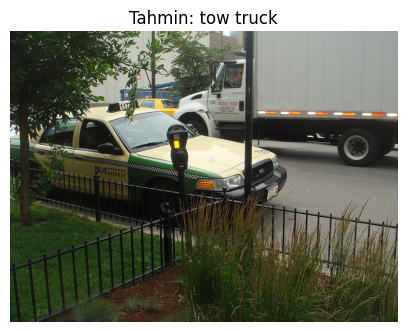

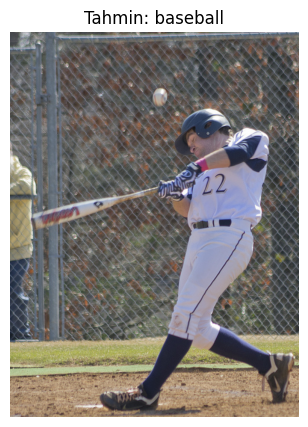

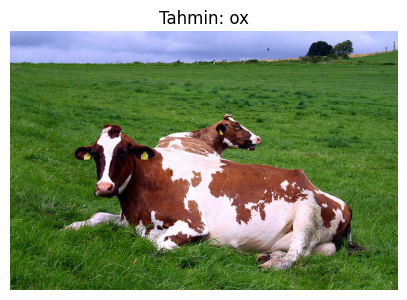

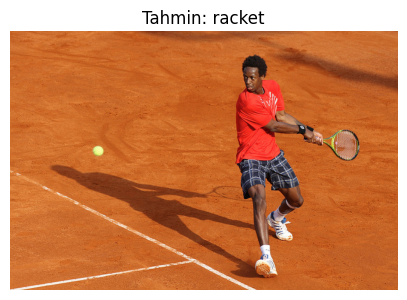

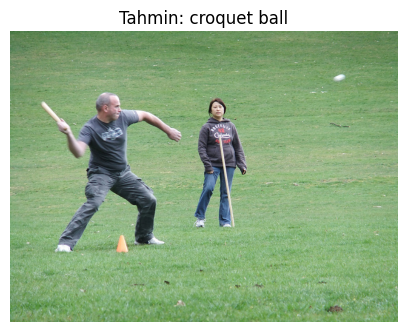

In [8]:
from glob import glob
import os, cv2
from PIL import Image
import torch.nn.functional as F

# Doğru klasör: Kaggle dataset yolu
IMG_DIR = "/kaggle/input/2017-2017/test2017/test2017"

paths = sorted(glob(os.path.join(IMG_DIR, "*.jpg")))
print("Bulunan görsel:", len(paths))

for pth in paths[:5]:
    bgr = cv2.imread(pth)
    if bgr is None:
        print("Okunamadı:", pth)
        continue
    pil = Image.fromarray(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    tens = base_transform(pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        prob = F.softmax(model(tens), dim=1)[0]
    idx = int(prob.argmax())
    label = idx_to_class[idx]
    show_image(bgr, title=f"Tahmin: {label}")


In [9]:
# Hücre 8A — COCO -> ImageFolder (path düzeltildi + val düzeltildi)
import os, random, shutil
from pathlib import Path
from pycocotools.coco import COCO

random.seed(42)

# 0) COCO kökü ve dizinleri esnek çöz
INPUT = Path("/kaggle/input")
candidates = [p for p in INPUT.iterdir() if p.is_dir() and (p/"annotations_trainval2017").exists()]
assert candidates, "COCO klasörü bulunamadı (/kaggle/input)."
COCO_ROOT = candidates[0]

def resolve_split_dir(root: Path, split: str) -> Path:
    a = root / split / split          # örn: 2017-2017/train2017/train2017
    b = root / split                  # örn: 2017-2017/train2017
    if a.exists(): return a
    if b.exists(): return b
    raise FileNotFoundError(f"{split} dizini bulunamadı: {a} ya da {b}")

TRAIN_DIR = resolve_split_dir(COCO_ROOT, "train2017")
VAL_DIR   = resolve_split_dir(COCO_ROOT, "val2017")

def find_ann(root: Path, split: str) -> str:
    for base in ["annotations_trainval2017", "annotations"]:
        p = root / base
        if p.exists():
            hits = list(p.rglob(f"instances_{split}.json"))
            if hits: return str(hits[0])
    raise FileNotFoundError(f"instances_{split}.json bulunamadı")

ANN_TRAIN = find_ann(COCO_ROOT, "train2017")
ANN_VAL   = find_ann(COCO_ROOT, "val2017")

print("COCO_ROOT:", COCO_ROOT)
print("TRAIN_DIR:", TRAIN_DIR)
print("VAL_DIR  :", VAL_DIR)
print("ANN_TRAIN:", ANN_TRAIN)
print("ANN_VAL  :", ANN_VAL)

coco_tr = COCO(ANN_TRAIN)
coco_va = COCO(ANN_VAL)

# 1) Hedef sınıflar ve kopyalanacak adetler
target_class_names = ["person","car","dog","cat","bicycle"]
max_train_per_class = 120
max_val_per_class   = 30

DATA_ROOT = Path("./data")
(TRAIN_OUT := DATA_ROOT/"train").mkdir(parents=True, exist_ok=True)
(VAL_OUT   := DATA_ROOT/"val").mkdir(parents=True, exist_ok=True)

name_to_id_tr = {c["name"]: c["id"] for c in coco_tr.loadCats(coco_tr.getCatIds())}
name_to_id_va = {c["name"]: c["id"] for c in coco_va.loadCats(coco_va.getCatIds())}

used_train, used_val = set(), set()

def pick_ids(coco_api, cid, used_set, n):
    ids = coco_api.getImgIds(catIds=[cid])
    random.shuffle(ids)
    res = []
    for iid in ids:
        if iid in used_set: 
            continue
        res.append(iid)
        used_set.add(iid)
        if len(res) >= n:
            break
    return res

def copy_by_ids(coco_api, ids, src_dir: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    ok = 0
    for iid in ids:
        info = coco_api.loadImgs([iid])[0]
        src = src_dir / info["file_name"]
        dst = out_dir / info["file_name"]
        if not src.exists():
            print(f"[Yok] {src}")   # yanlış path kalmadıysa bu çok az görünür
            continue
        if not dst.exists():
            shutil.copy2(src, dst)
        ok += 1
    return ok

for cname in target_class_names:
    if cname not in name_to_id_tr:
        print(f"[Uyarı] Train anotasyonunda sınıf yok: {cname}")
        continue
    cid_tr = name_to_id_tr[cname]
    cid_va = name_to_id_va.get(cname, cid_tr)

    tr_ids = pick_ids(coco_tr, cid_tr, used_train, max_train_per_class)
    va_ids = pick_ids(coco_va, cid_va, used_val,   max_val_per_class)

    tr_ok = copy_by_ids(coco_tr, tr_ids, TRAIN_DIR, TRAIN_OUT/cname)
    va_ok = copy_by_ids(coco_va, va_ids, VAL_DIR,   VAL_OUT/cname)

    print(f"{cname:10s} -> train:{tr_ok:3d}  val:{va_ok:3d}")

print("\nHazır! './data/train' ve './data/val' oluşturuldu.")


COCO_ROOT: /kaggle/input/2017-2017
TRAIN_DIR: /kaggle/input/2017-2017/train2017/train2017
VAL_DIR  : /kaggle/input/2017-2017/val2017/val2017
ANN_TRAIN: /kaggle/input/2017-2017/annotations_trainval2017/annotations/instances_train2017.json
ANN_VAL  : /kaggle/input/2017-2017/annotations_trainval2017/annotations/instances_val2017.json
loading annotations into memory...
Done (t=20.47s)
creating index...
index created!
loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
person     -> train:120  val: 30
car        -> train:120  val: 30
dog        -> train:120  val: 30
cat        -> train:120  val: 30
bicycle    -> train:120  val: 30

Hazır! './data/train' ve './data/val' oluşturuldu.


In [10]:
# Hücre 9 — DataLoader + Model (COCO→ImageFolder uyumlu)

import os, random, numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.models as models

# Cihaz ve tohumlar
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42); np.random.seed(42); torch.manual_seed(42)

# 1) Dönüşümler (ImageNet mean/std)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tf = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tf = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Not: önceki hücrelerde kullandığın 'base_transform' inference/Grad-CAM için
base_transform = val_tf

# 2) Dataset ve DataLoader
DATA_ROOT = "./data"  # Hücre 8A'nın çıktısı
train_ds = ImageFolder(os.path.join(DATA_ROOT, "train"), transform=train_tf)
val_ds   = ImageFolder(os.path.join(DATA_ROOT, "val"),   transform=val_tf)

# Sınıf eşlemeleri (diğer hücrelerde kullanacağız)
class_to_idx = train_ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Sınıflar:", train_ds.classes)

BATCH_SIZE   = 32
NUM_WORKERS  = 2  # Kaggle'da güvenli seçim
PIN_MEMORY   = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f"Train örnek: {len(train_ds)} | Val örnek: {len(val_ds)}")

# 3) Model: ResNet50'yi 5 sınıfa uyarla
num_classes = len(train_ds.classes)
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)

# İstersen omurgayı dondur (faster fine-tuning):
for name, param in model.named_parameters():
    param.requires_grad = False
# Sadece sınıflandırıcıyı eğitelim (istersen ileride katmanları açarsın)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model = model.to(DEVICE)

# 4) Kayı


Sınıflar: ['bicycle', 'car', 'cat', 'dog', 'person']
Train örnek: 600 | Val örnek: 150


In [13]:
# Hücre 10 — train/val döngüsü, yeni torch.amp API, eksikleri otomatik tamamlama
import time, math
from collections import defaultdict
import torch

# ---- Güvenlik: Hücre 9 çalıştı mı? (train_loader, val_loader, model) ----
assert 'model' in globals(), "Model bulunamadı. Önce Hücre 9'u çalıştır."
assert 'train_loader' in globals() and 'val_loader' in globals(), "DataLoader'lar yok. Önce Hücre 9'u çalıştır."
assert 'idx_to_class' in globals(), "idx_to_class yok. Önce Hücre 9'u çalıştır."
assert 'DEVICE' in globals(), "DEVICE değişkeni yok. Önce Hücre 9'u çalıştır."

# ---- Eksik olan öğeleri varsayılanlarla tamamla ----
if 'criterion' not in globals():
    criterion = torch.nn.CrossEntropyLoss()
    print("[Bilgi] criterion yoktu, CrossEntropyLoss ile tanımlandı.")

if 'optimizer' not in globals():
    # Hücre 9'da genelde sadece fc katmanı eğitiliyordu; burada da öyle yapalım:
    params = (p for p in model.parameters() if p.requires_grad)
    optimizer = torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-4)
    print("[Bilgi] optimizer yoktu, AdamW(lr=1e-3) ile tanımlandı.")

if 'scheduler' not in globals():
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    print("[Bilgi] scheduler yoktu, CosineAnnealingLR ile tanımlandı.")

# ---- AMP (yeni API) ----
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    amp_autocast = torch.amp.autocast  # device_type='cuda' vererek kullanacağız
    scaler = torch.amp.GradScaler('cuda')  # yeni önerilen kullanım
else:
    from contextlib import nullcontext
    amp_autocast = lambda **kw: nullcontext()  # CPU'da AMP yok
    class _NoScaler:
        def scale(self, x): return x
        def step(self, opt): opt.step()
        def update(self): pass
    scaler = _NoScaler()

# ---- Hiperparametreler ----
EPOCHS = 8
ACCUM_STEPS = 1  # gradient accumulation gerekirse >1 yap

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running = defaultdict(float)
    n, correct = 0, 0

    optimizer.zero_grad(set_to_none=True)
    for i, (xb, yb) in enumerate(loader, 1):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        with amp_autocast(device_type='cuda', dtype=torch.float16) if USE_CUDA else amp_autocast():
            logits = model(xb)
            loss = criterion(logits, yb)

        # AMP/Non-AMP uyumlu geri yayılım
        if ACCUM_STEPS > 1:
            if USE_CUDA:
                scaler.scale(loss / ACCUM_STEPS).backward()
            else:
                (loss / ACCUM_STEPS).backward()
        else:
            if USE_CUDA:
                scaler.scale(loss).backward()
            else:
                loss.backward()

        if i % ACCUM_STEPS == 0:
            if USE_CUDA:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        # metrikler
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        n += yb.size(0)
        running["loss"] += loss.item() * yb.size(0)

    return {"loss": running["loss"] / n, "acc": correct / n}

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running = defaultdict(float)
    n, correct = 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        n += yb.size(0)
        running["loss"] += loss.item() * yb.size(0)
    return {"loss": running["loss"] / n, "acc": correct / n}

# ---- Eğitim döngüsü ----
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0
best_path = "best_model.pth"

start = time.time()
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    tr = train_one_epoch(model, train_loader, optimizer, criterion)
    va = evaluate(model, val_loader, criterion)
    scheduler.step()

    history["train_loss"].append(tr["loss"]); history["train_acc"].append(tr["acc"])
    history["val_loss"].append(va["loss"]);   history["val_acc"].append(va["acc"])

    if va["acc"] > best_val_acc:
        best_val_acc = va["acc"]
        torch.save({"model": model.state_dict(),
                    "class_to_idx": class_to_idx}, best_path)

    dt = time.time() - t0
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr['loss']:.4f} acc={tr['acc']:.3f} | "
          f"val_loss={va['loss']:.4f} acc={va['acc']:.3f} "
          f"({dt:.1f}s)")

print(f"En iyi val acc: {best_val_acc:.3f}  -> {best_path}")
print(f"Toplam süre: {time.time() - start:.1f}s")


[Bilgi] criterion yoktu, CrossEntropyLoss ile tanımlandı.
[Bilgi] optimizer yoktu, AdamW(lr=1e-3) ile tanımlandı.
[Bilgi] scheduler yoktu, CosineAnnealingLR ile tanımlandı.
[01/8] train_loss=1.3743 acc=0.470 | val_loss=1.0890 acc=0.607 (4.5s)
[02/8] train_loss=1.0441 acc=0.615 | val_loss=0.9291 acc=0.680 (4.2s)
[03/8] train_loss=0.9211 acc=0.680 | val_loss=0.8839 acc=0.673 (4.1s)
[04/8] train_loss=0.8461 acc=0.710 | val_loss=0.8526 acc=0.673 (4.1s)
[05/8] train_loss=0.7985 acc=0.720 | val_loss=0.8418 acc=0.680 (4.1s)
[06/8] train_loss=0.7446 acc=0.750 | val_loss=0.8287 acc=0.687 (4.3s)
[07/8] train_loss=0.7268 acc=0.757 | val_loss=0.8265 acc=0.680 (4.1s)
[08/8] train_loss=0.7200 acc=0.748 | val_loss=0.8249 acc=0.680 (4.0s)
En iyi val acc: 0.687  -> best_model.pth
Toplam süre: 33.3s


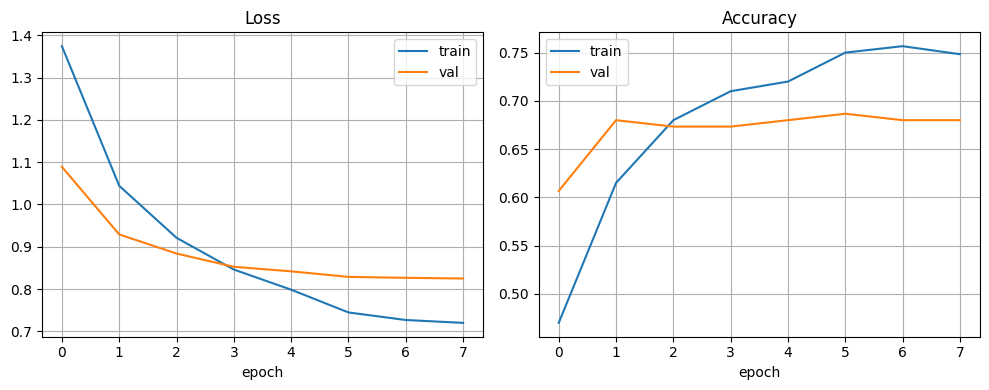

In [14]:
# Hücre 11 — eğitim/val loss & acc grafik
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"],   label="val")
plt.title("Loss"); plt.xlabel("epoch"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"],   label="val")
plt.title("Accuracy"); plt.xlabel("epoch"); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()


              precision    recall  f1-score   support

     bicycle      0.562     0.600     0.581        30
         car      0.654     0.567     0.607        30
         cat      0.844     0.900     0.871        30
         dog      0.647     0.733     0.688        30
      person      0.731     0.633     0.679        30

    accuracy                          0.687       150
   macro avg      0.688     0.687     0.685       150
weighted avg      0.688     0.687     0.685       150



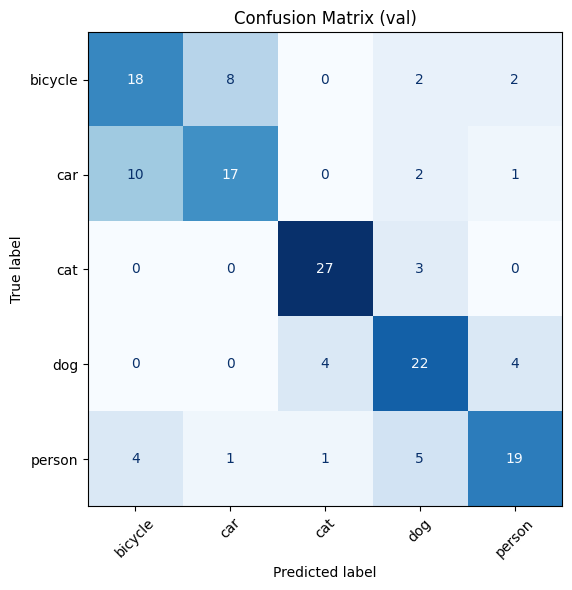

In [15]:
# Hücre 12 — classification report + confusion matrix
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# En iyi modeli geri yükle (garanti olsun)
ckpt = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

all_y_true, all_y_pred = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        pred = logits.argmax(1).cpu().numpy()
        all_y_pred.append(pred)
        all_y_true.append(yb.numpy())

y_true = np.concatenate(all_y_true)
y_pred = np.concatenate(all_y_pred)

target_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, xticks_rotation=45, values_format='d', cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (val)")
plt.tight_layout(); plt.show()


In [16]:
# Hücre 13 — tek görsel tahmin + mini galeri
import torch.nn.functional as F
import cv2, random
from pathlib import Path
import matplotlib.pyplot as plt

# Yardımcı: tek görselden tahmin
def predict_image(path: str, topk=5):
    bgr = cv2.imread(path)
    assert bgr is not None, f"Okunamadı: {path}"
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    tens = base_transform(pil).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        logits = model(tens)
        prob = F.softmax(logits, dim=1)[0].cpu().numpy()

    idxs = prob.argsort()[::-1][:topk]
    labels = [idx_to_class[i] for i in idxs]
    scores = [float(prob[i]) for i in idxs]
    return bgr, list(zip(labels, scores)), idxs[0]

# Örnek: val setinden rastgele 8 görsel göster
def show_samples(n=8):
    paths = [p for p, _ in val_ds.samples]
    sample = random.sample(paths, min(n, len(paths)))

    cols = 4
    rows = math.ceil(len(sample)/cols)
    plt.figure(figsize=(12, 3*rows))
    for i, p in enumerate(sample, 1):
        bgr, topk, _ = predict_image(p, topk=3)
        txt = ", ".join([f"{lbl}:{score:.2f}" for lbl, score in topk])
        ax = plt.subplot(rows, cols, i)
        ax.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
        ax.set_title(Path(p).parent.name + "\n" + txt, fontsize=9)
        ax.axis("off")
    plt.tight_layout(); plt.show()

# Kullanım:
# bgr, topk, cls_idx = predict_image("./data/val/dog/000000xxxxxx.jpg")
# print(topk)
# show_samples(8)
print("Hazır. predict_image(path) ve show_samples(n) fonksiyonları yüklendi.")


Hazır. predict_image(path) ve show_samples(n) fonksiyonları yüklendi.


In [17]:
# Hücre 14 — Grad-CAM (harici paketsiz)
import torch, cv2, numpy as np, matplotlib.pyplot as plt

def gradcam_overlay(model, img_bgr, class_idx, img_tensor):
    """
    img_bgr: orijinal BGR (H,W,3)
    class_idx: hedef sınıf indeksi (int)
    img_tensor: model'e girecek 1x3x224x224 tensör (base_transform ile)
    """
    model.eval()
    target_block = model.layer4[-1]
    acts, grads = [], []

    def fwd_hook(m, inp, out):  acts.append(out.detach())
    def bwd_hook(m, gin, gout): grads.append(gout[0].detach())

    h1 = target_block.register_forward_hook(fwd_hook)
    h2 = target_block.register_full_backward_hook(bwd_hook)

    model.zero_grad(set_to_none=True)
    logits = model(img_tensor)
    score = logits[0, class_idx]
    score.backward()

    h1.remove(); h2.remove()

    A = acts[0]                               # [1,C,h,w]
    G = grads[0]                              # [1,C,h,w]
    weights = G.mean(dim=(2,3), keepdim=True) # [1,C,1,1]
    cam = torch.relu((weights * A).sum(dim=1, keepdim=True))  # [1,1,h,w]
    cam = torch.nn.functional.interpolate(cam, size=img_tensor.shape[-2:], mode='bilinear', align_corners=False)
    cam = cam[0,0].cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    H, W = img_bgr.shape[:2]
    cam_up = cv2.resize(cam, (W, H), interpolation=cv2.INTER_LINEAR)

    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    heat = cv2.applyColorMap(np.uint8(255*cam_up), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    overlay = np.clip(0.5*rgb + 0.5*heat, 0, 1)

    return (overlay*255).astype(np.uint8)

def show_gradcam(path):
    # tek satır rahat kullanım
    bgr = cv2.imread(path); assert bgr is not None, path
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    tens = base_transform(pil).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(tens)
    cls_idx = int(logits.argmax(1).item())

    vis = gradcam_overlay(model, bgr, cls_idx, tens)
    plt.figure(figsize=(5,5))
    plt.imshow(vis); plt.axis("off")
    plt.title(f"Grad-CAM → {idx_to_class[cls_idx]}")
    plt.show()

print("Hazır. show_gradcam('.../resim.jpg') ile görselleştirebilirsin.")


Hazır. show_gradcam('.../resim.jpg') ile görselleştirebilirsin.


In [18]:
# Hücre 15 — export/import ve yardımcılar
import torch, json

# Sınıf adlarını da ayrı kaydetmek istersen:
with open("classes.json", "w") as f:
    json.dump([idx_to_class[i] for i in range(len(idx_to_class))], f)
print("Kaydedildi: classes.json")

# TorchScript (isteğe bağlı)
example = torch.randn(1,3,224,224).to(DEVICE)
traced = torch.jit.trace(model, example)
traced.save("model_traced.pt")
print("Kaydedildi: model_traced.pt")

# Yeniden yüklemek:
# ckpt = torch.load("best_model.pth", map_location=DEVICE)
# model.load_state_dict(ckpt["model"]); model.eval()


Kaydedildi: classes.json
Kaydedildi: model_traced.pt


In [19]:
# Hücre 16 — opsiyonel fine-tune: son blokları açıp küçük LR ile eğit
# Bu hücreyi sadece birkaç epok daha iyileştirme istediğinde çalıştır.
for name, p in model.named_parameters():
    p.requires_grad = False

for name, p in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        p.requires_grad = True

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=3e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

EPOCHS_FT = 3
best_ft = 0.0
for epoch in range(1, EPOCHS_FT+1):
    tr = train_one_epoch(model, train_loader, optimizer, criterion)
    va = evaluate(model, val_loader, criterion)
    scheduler.step()

    if va["acc"] > best_ft:
        best_ft = va["acc"]
        torch.save({"model": model.state_dict(),
                    "class_to_idx": class_to_idx}, "best_model_finetune.pth")

    print(f"[FT {epoch}/{EPOCHS_FT}] "
          f"train_acc={tr['acc']:.3f} val_acc={va['acc']:.3f}")

print("Fine-tune bitti. En iyi:", best_ft)


[FT 1/3] train_acc=0.737 val_acc=0.680
[FT 2/3] train_acc=0.787 val_acc=0.693
[FT 3/3] train_acc=0.817 val_acc=0.687
Fine-tune bitti. En iyi: 0.6933333333333334


In [23]:
# Hücre 18-Fix — Uygun klasörü bul, toplu tahmin yap, CSV/TXT oluştur
import os, sys, json, time
from pathlib import Path
import numpy as np
import pandas as pd
import torch, torch.nn.functional as F
import cv2
from PIL import Image

# --- Zorunlu kontroller ---
assert 'model' in globals(), "Model tanımlı değil. Önce Hücre 9/10'u çalıştır."
assert 'DEVICE' in globals(), "DEVICE değişkeni tanımlı değil. Önce önceki hücreleri çalıştır."
# idx_to_class yoksa class_to_idx'ten üretmeyi dene
if 'idx_to_class' not in globals():
    if 'class_to_idx' in globals():
        idx_to_class = {v:k for k,v in class_to_idx.items()}
        print("[Bilgi] idx_to_class türetildi.")
    else:
        raise RuntimeError("Sınıf isimleri bulunamadı (idx_to_class / class_to_idx).")

# --- base_transform yoksa makul bir varsayılan tanımla ---
if 'base_transform' not in globals():
    try:
        from torchvision import transforms
        base_transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std =[0.229,0.224,0.225]),
        ])
        print("[Bilgi] base_transform varsayılan tanımlandı (224x224).")
    except Exception as e:
        raise RuntimeError("torchvision gerekli. Lütfen önceki kurulum hücrelerini çalıştırın.") from e

# --- Tekil yardımcılar ---
def _topk_from_logits(logits, k):
    prob = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
    idxs = prob.argsort()[::-1][:k]
    labels = [idx_to_class[i] for i in idxs]
    scores = [float(prob[i]) for i in idxs]
    return labels, scores, int(idxs[0]), float(prob[idxs[0]])

def _annotate(bgr, text):
    out = bgr.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale, thick = 0.8, 2
    (w, h), _ = cv2.getTextSize(text, font, scale, thick)
    cv2.rectangle(out, (10,10), (20+w, 20+h), (0,0,0), -1)
    cv2.putText(out, text, (15, 20+h-10), font, scale, (255,255,255), thick, cv2.LINE_AA)
    return out

# --- predict_folder tanımlı değilse ekle ---
if 'predict_folder' not in globals():
    def predict_folder(in_dir, out_csv="predictions.csv", out_txt="predictions.txt",
                       write_overlay=False, out_dir="./pred_output",
                       topk=5, recursive=True):
        in_dir = Path(in_dir); assert in_dir.exists(), f"Klasör yok: {in_dir}"
        exts = {".jpg",".jpeg",".png",".bmp",".webp"}
        files = [p for p in (in_dir.rglob("*") if recursive else in_dir.glob("*"))
                 if p.suffix.lower() in exts]
        if not files:
            print("Görsel bulunamadı:", in_dir); return None

        if write_overlay:
            Path(out_dir).mkdir(parents=True, exist_ok=True)

        class_names = set(idx_to_class.values())
        rows = []

        model.eval()
        for p in files:
            bgr = cv2.imread(str(p))
            if bgr is None:
                continue
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            tens = base_transform(Image.fromarray(rgb)).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                logits = model(tens)

            labels, scores, pred_idx, pred_prob = _topk_from_logits(logits, topk)
            pred_label = labels[0]
            true_label = p.parent.name if p.parent.name in class_names else ""

            rows.append({
                "rel_path": str(p.relative_to(in_dir)),
                "abs_path": str(p.resolve()),
                "true_label": true_label,
                "pred_label": pred_label,
                "pred_prob": round(pred_prob, 6),
                "topk_labels": "|".join(labels),
                "topk_probs":  "|".join([f"{s:.6f}" for s in scores]),
            })

            if write_overlay:
                vis = _annotate(bgr, f"{pred_label} ({pred_prob:.2f})")
                cv2.imwrite(str(Path(out_dir)/p.name), vis)

        df = pd.DataFrame(rows)
        df.to_csv(out_csv, index=False, encoding="utf-8")
        with open(out_txt, "w", encoding="utf-8") as f:
            for r in rows:
                f.write(f"{r['rel_path']} => {r['pred_label']} ({r['pred_prob']:.2f})\n")

        print(f"Kaydedildi: {out_csv} | satır={len(df)}")
        print(f"Kaydedildi: {out_txt}")
        if write_overlay:
            print("Annotasyonlu görseller:", Path(out_dir).resolve())

        # Hızlı accuracy (varsa)
        labeled = [r for r in rows if r["true_label"]]
        if labeled:
            acc = np.mean([r["true_label"] == r["pred_label"] for r in labeled])
            print(f"Doğruluk (true_label olanlar): {acc:.3f}")

        return df

# --- En iyi modeli yüklemeyi dene ---
loaded = False
for ckpt in ["best_model_finetune.pth", "best_model.pth"]:
    if Path(ckpt).exists():
        ck = torch.load(ckpt, map_location=DEVICE)
        model.load_state_dict(ck["model"])
        model.eval()
        print(f"Yüklendi: {ckpt}")
        loaded = True
        break
if not loaded:
    print("[Uyarı] Kayıtlı en iyi model bulunamadı; mevcut model ile devam.")

# --- Aday klasörleri sırala ve ilk dolu olanı seç ---
def has_images(d):
    p = Path(d)
    if not p.exists(): return False
    for ext in (".jpg",".jpeg",".png",".bmp",".webp"):
        if any(p.rglob(f"*{ext}")):
            return True
    return False

candidates = ["./inference", "./data/val", "./data/train", "./pred_infer", "./pred_val", "./output"]
chosen = None
for c in candidates:
    if has_images(c):
        chosen = c
        break

if chosen is None:
    print("⚠️ Hiç görsel bulunamadı. Lütfen birkaç resmi './inference' klasörüne koy ve bu hücreyi tekrar çalıştır.")
else:
    print(f"Kullanılacak klasör: {chosen}")
    df = predict_folder(chosen, out_csv="auto_pred.csv", out_txt="auto_pred.txt",
                        write_overlay=True, out_dir="./pred_auto", topk=5, recursive=True)
    if df is not None:
        print("\nİlk 10 satır:")
        print(df.head(10))
        print("\nCSV yolu:", Path("auto_pred.csv").resolve())
        print("TXT yolu :", Path("auto_pred.txt").resolve())


Yüklendi: best_model_finetune.pth
Kullanılacak klasör: ./data/val
Kaydedildi: auto_pred.csv | satır=150
Kaydedildi: auto_pred.txt
Annotasyonlu görseller: /kaggle/working/pred_auto
Doğruluk (true_label olanlar): 0.693

İlk 10 satır:
                   rel_path  \
0  bicycle/000000306136.jpg   
1  bicycle/000000549390.jpg   
2  bicycle/000000038829.jpg   
3  bicycle/000000261888.jpg   
4  bicycle/000000351530.jpg   
5  bicycle/000000291634.jpg   
6  bicycle/000000411938.jpg   
7  bicycle/000000135670.jpg   
8  bicycle/000000233727.jpg   
9  bicycle/000000203317.jpg   

                                            abs_path true_label pred_label  \
0  /kaggle/working/data/val/bicycle/000000306136.jpg    bicycle        car   
1  /kaggle/working/data/val/bicycle/000000549390.jpg    bicycle    bicycle   
2  /kaggle/working/data/val/bicycle/000000038829.jpg    bicycle    bicycle   
3  /kaggle/working/data/val/bicycle/000000261888.jpg    bicycle    bicycle   
4  /kaggle/working/data/val/bicycle/

Yüklendi: auto_pred.csv | satır=150

Rastgele 10 satır:
                     rel_path  \
107      dog/000000318238.jpg   
132   person/000000485480.jpg   
123   person/000000248112.jpg   
9    bicycle/000000203317.jpg   
104      dog/000000263463.jpg   
119      dog/000000377575.jpg   
50       cat/000000434996.jpg   
136   person/000000061960.jpg   
14   bicycle/000000301376.jpg   
99       dog/000000061471.jpg   

                                              abs_path true_label pred_label  \
107      /kaggle/working/data/val/dog/000000318238.jpg        dog        dog   
132   /kaggle/working/data/val/person/000000485480.jpg     person     person   
123   /kaggle/working/data/val/person/000000248112.jpg     person        dog   
9    /kaggle/working/data/val/bicycle/000000203317.jpg    bicycle    bicycle   
104      /kaggle/working/data/val/dog/000000263463.jpg        dog        dog   
119      /kaggle/working/data/val/dog/000000377575.jpg        dog        dog   
50       /kaggle/wor

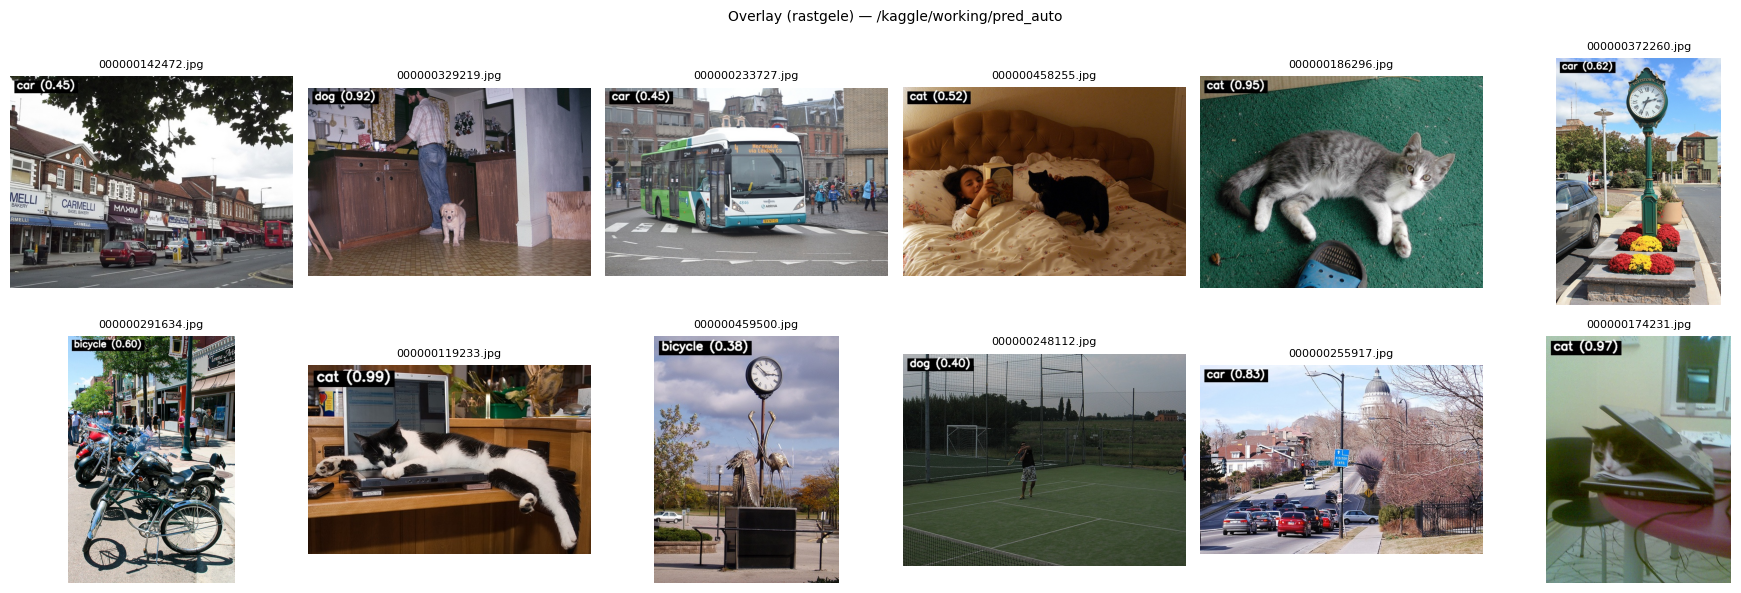

In [28]:
# Hücre 19 — Rastgele örneklerle inceleme + overlay rastgele önizleme
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import cv2, random
from math import ceil

def _find_existing(paths):
    for p in paths:
        if Path(p).exists():
            return p
    return None

# 1) CSV'yi bul ve yükle (auto_pred.csv öncelik)
csv_path = _find_existing(["auto_pred.csv", "val_pred.csv", "infer_pred.csv", "predictions.csv"])
assert csv_path is not None, "CSV bulunamadı. Lütfen önce Hücre 18-Fix/18 ile CSV üret."
df = pd.read_csv(csv_path)

print(f"Yüklendi: {csv_path} | satır={len(df)}\n")

# Rastgele 10 satır göster (satır azsa tamamını al)
k = min(10, len(df))
print(f"Rastgele {k} satır:")
print(df.sample(n=k, random_state=None), "\n")

# 2) Doğruluk ve yanlışlardan rastgele örnekler (true_label varsa)
if "true_label" in df.columns:
    labeled = df[df.true_label.notna() & (df.true_label != "")]
    if len(labeled):
        acc = (labeled.true_label == labeled.pred_label).mean()
        print(f"Genel doğruluk (etiketli satırlar): {acc:.3f}  n={len(labeled)}")

        # sınıf bazında özet
        per = []
        for c in sorted(labeled.true_label.unique()):
            sub = labeled[labeled.true_label == c]
            per.append((c, len(sub), (sub.true_label == sub.pred_label).mean()))
        print("Sınıf bazında (label, n, acc):")
        for c, n, a in per:
            print(f" - {c:15s} n={n:4d} acc={a:.3f}")

        # en güvenilen yanlışlardan rastgele örnekler
        wrong = labeled[labeled.true_label != labeled.pred_label].copy()
        if not wrong.empty:
            k = min(15, len(wrong))
            print(f"\nRastgele {k} yanlış örnek:")
            print(wrong.sample(n=k, random_state=None)[["rel_path","true_label","pred_label","pred_prob"]], "\n")
    else:
        print("true_label sütunu var ama dolu satır yok; sadece tahminler gösterilir.\n")
else:
    print("true_label sütunu yok; sadece tahminler listelenir.\n")

# 3) Overlay klasöründen RASTGELE görselleri göster
def _show_overlay_samples(folder, n=12, shuffle=True):
    p = Path(folder)
    exts = {".jpg",".jpeg",".png",".bmp",".webp"}
    imgs = [q for q in p.glob("*") if q.suffix.lower() in exts]
    if not imgs:
        print(f"Görsel yok: {p.resolve()}")
        return
    if shuffle:
        random.shuffle(imgs)
    imgs = imgs[:min(n, len(imgs))]

    cols = 6
    rows = ceil(len(imgs)/cols)
    plt.figure(figsize=(3*cols, 3*rows))
    for i, fp in enumerate(imgs, 1):
        img = cv2.imread(str(fp))
        if img is None: 
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img)
        ax.set_title(fp.name[:22], fontsize=8)
        ax.axis("off")
    plt.suptitle(f"Overlay (rastgele) — {Path(folder).resolve()}", fontsize=10)
    plt.tight_layout()
    plt.show()

overlay_dirs = ["./pred_auto", "./pred_val", "./pred_infer", "./pred_output", "./predictions_vis"]
ov = next((d for d in overlay_dirs if Path(d).exists()), None)

if ov:
    print(f"Overlay klasörü bulundu: {ov}  -> rastgele örnekler gösteriliyor...")
    _show_overlay_samples(ov, n=12, shuffle=True)
else:
    print("Overlay klasörü bulunamadı. Hücre 18(-Fix) içinde write_overlay=True olmalı.")
